# PA3 - DynaQ - Abe Leite {-}

In [ ]:
# This code can be used to add a folder in the repository to the Python import
# path, irrespective of whether the notebook is being run in colab or Jupyter.
# (C) 2020 Abe Leite, Indiana University Bloomington
# This code block is released under MIT license. Feel free to make use of
# this code in any projects so long as you reproduce this text.

import os
import sys
import subprocess

repo_URL = 'https://github.com/ajleite/dyna-q-exploration'
repo_name = repo_URL.split('/')[-1]
# top level of repository. --AL Mar 10 2022
code_folder = ''

try:
  repo_path = subprocess.check_output('git rev-parse --show-toplevel', shell=True).decode().strip()
except subprocess.CalledProcessError:
  os.system(f'git clone {repo_URL} --depth 1')
  repo_path = os.path.abspath(repo_name)

code_path = os.path.join(repo_path, code_folder)
sys.path.append(code_path)
print(f'Loading code from {code_path}')

In [ ]:
# don't forget the boilerplate --AL Mar 10 2022
!apt-get update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym

In [ ]:
# we'll go to the repo path in order to work with saved models. --AL Mar 10 2022
os.chdir(code_path)

In [ ]:
import pickle

import numpy as np
import scipy.stats as st
import tensorflow as tf

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

import gym

# 0 Tasks {-}

For this assignment I make use of one task: the Atari Pong task. I did the same preprocessing here that I did on the first programming assignment, and I will discuss it again now. Additionally, I fed the image output through a CNN that had been trained for a previous controller during PA1.

## 0.1 Pong task {-}

I preprocessed the game's video output as follows: (1) I disentangled the colors of the player, opponent, and ball; (2) I scaled the game field down by a factor of 2; (3) I restricted the image to the game field; and (4) I added a time-delayed image so that the agent could extract velocity information from the game. The resulting observations had dimensions of (80, 80, 6). Additionally, (4) I restricted the agent's actions to upwards and downwards motion (not including any no-op action); and finally (5) I treated each point, rather than each full game, as a distinct episode.

I used a CNN to extract features from the Pong task. In particular, I the feature extractors from a CNN that had been trained end-to-end with a Monte-Carlo reinforcement learning algorithm.

Please see all of this preprocessing code below:

In [ ]:
def downscale(image):
    new_image = np.zeros((image.shape[0]//2, image.shape[1]//2, image.shape[2]), image.dtype)
    for new_row in range(new_image.shape[0]):
        old_row = new_row * 2
        for new_col in range(new_image.shape[1]):
            old_col = new_col * 2
            new_image[new_row, new_col] = image[old_row, old_col]
    return new_image

def preprocess(image):
    bg = image[0, -1]

    # restrict to the playing field
    field = image[17:97]

    ball_color = np.uint8([[[236, 236, 236]]])
    P1_color = np.uint8([[[92, 186, 92]]])
    P2_color = np.uint8([[[213, 130, 74]]])

    # disentangle features insofar as possible
    is_ball = np.all(field == ball_color, axis=-1)
    is_P1 = np.all(field == P1_color, axis=-1)
    is_P2 = np.all(field == P2_color, axis=-1)
    new_image = np.float32(np.stack([is_ball, is_P1, is_P2], axis=2))

    return new_image

class PongTaskWithCNN:
    def __init__(self, rng):
        self.pong_env = gym.make('PongNoFrameskip-v0')
        self.obs_buffer = [None, None, None]
        self.obs_index = -3
        self.points = 0

        self.rng = rng
        self.CNN = load_CNN()

        self.real_reset()

        def real_reset(self):
        self.obs_index = -3
        self.points = 0

        self.pong_env.seed(int(self.rng.integers(2**31)))
        raw_obs = self.pong_env.reset()
        obs = preprocess(downscale(raw_obs))
        self.obs_buffer[self.obs_index] = obs
        self.obs_index += 1

        # this returns the output of the CNN at the linear_decisions_2 layer, rather than the action quality layer.
        return self.CNN.apply_headless(np.concatenate([obs, obs], axis=2))

    def reset(self):
        if self.obs_index >= 0:
            self.obs_buffer[0] = self.obs_buffer[self.obs_index-1]
            self.obs_index = -3
        return self.CNN.apply_headless(np.concatenate([self.obs_buffer[0], self.obs_buffer[0]], axis=2))

    def step(self, action):
        if action == 0:
            action = 2
        else:
            action = 5
        raw_obs, reward, terminal, info = self.pong_env.step(action)

        if terminal:
            if not reward:
                if self.points < 0:
                    reward = -1.
                else:
                    reward = 1.
    
            combined_obs = self.real_reset()
        else:
            obs = preprocess(downscale(raw_obs))

            if self.obs_index < 0:
                old_obs = self.obs_buffer[0]
            else:
                old_obs = self.obs_buffer[self.obs_index]

            self.obs_buffer[self.obs_index] = obs
            self.obs_index += 1
            if self.obs_index >= 3:
                self.obs_index = 0

            combined_obs = self.CNN.apply_headless(np.concatenate([obs, old_obs], axis=2))

            if reward:
                terminal = 1
                self.points += reward

        return combined_obs, reward, terminal, info

    def render(self):
        self.pong_env.render()

## 0.3 Simulation model {-}

The following cell contains boilerplate code for training an agent on an environment and saving the results. It greedily evaluates the policy every 50 training episodes in order to track how performance changes over time and preserve the best-performing weights.

In [ ]:
class Simulation:
    def __init__(self, agent, task, num_episodes, epsilon=0.25, path=None):
        self.agent = agent
        self.task = task

        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.path = path

        self.training_episode_rewards = []
        self.eval_episode_rewards = []
        self.eval_indices = []

        self.episode_behavior_entropy = []
        self.episode_dyn_rmse = []
        self.episode_Q_rmse = []

        self.best_weights = None
        self.best_100_episode_return = None

    def save_trace(self):
        if not self.path:
            return

        to_save = {'best_weights': self.best_weights, 'best_100_episode_return': self.best_100_episode_return,
            'training_episode_rewards': self.training_episode_rewards, 'eval_episode_rewards': self.eval_episode_rewards,
            'eval_indices': self.eval_indices,
            'dyn_rmse': self.episode_dyn_rmse, 'Q_rmse': self.episode_Q_rmse, 'behavior_entropy': self.episode_behavior_entropy}

        pickle.dump(to_save, open(self.path,'wb'))

    def evaluate(self, eval_index=None, render=False):
        eval_rewards = []
        for i in range(50):
            s = self.task.reset()
            t = False
            ep_return = 0

            while not t:
                a = self.agent.act(s, 0)

                s2, r, t, _ = self.task.step(a)
                s = s2
                ep_return += r

                if render:
                    self.task.render()

            # episode is over, record it
            eval_rewards.append(ep_return)
            print((eval_index, 'e', i, ep_return))

        self.eval_indices.append(eval_index)
        self.eval_episode_rewards.append(eval_rewards)

        # maintain best stats
        if self.best_100_episode_return is None or np.mean(eval_rewards) > self.best_100_episode_return:
            self.best_100_episode_return = np.mean(eval_rewards)
            self.best_weights = self.agent.Q_network.keras_network.get_weights()
        print('cycle', eval_index, 'mean eval:', np.mean(eval_rewards), 'best:', self.best_100_episode_return)
        self.save_trace()

    def run(self, render=False):
        timestep = 0

        for n in range(self.num_episodes):
            # gather greedy evaluation trajectories every 50 training episodes
            if not n % 50 and n:
                self.evaluate(n, render)

            # 1. gather training trajectories
            s = self.task.reset()
            t = False
            total_r = 0

            n_left = 0
            n_right = 0

            ep_Q_rmse = 0
            ep_Q_loss_den = 0
            ep_dyn_rmse = 0
            ep_dyn_loss_den = 0

            while not t:
                a = self.agent.act(s, self.epsilon)

                if a == 0:
                    n_left += 1
                else:
                    n_right += 1

                s2, r, t, _ = self.task.step(a)
                mean_Q_loss, mean_dyn_loss = self.agent.store(s, a, r, t, s2)
                s = s2
                total_r += r

                if not mean_Q_loss is None:
                    ep_Q_rmse += mean_Q_loss
                    ep_Q_loss_den += 1
                if not mean_dyn_loss is None:
                    ep_dyn_rmse += mean_dyn_loss
                    ep_dyn_loss_den += 1

            # episode is over, record it
            self.training_episode_rewards.append(total_r)
            print((n, 't', total_r))

            # calculate behavior entropy
            total_actions = n_left + n_right
            p_left = n_left / total_actions
            p_right = n_right / total_actions
            if p_left == 0 or p_right == 0:
                entropy = 0.
            else:
                entropy = -np.log2(p_left)*p_left + -np.log2(p_right)*p_right
            self.episode_behavior_entropy.append(entropy)

            if ep_Q_loss_den:
                self.episode_Q_rmse.append(ep_Q_rmse/ep_Q_loss_den)
                print(ep_Q_rmse/ep_Q_loss_den)
            if ep_dyn_loss_den:
                self.episode_dyn_rmse.append(ep_dyn_rmse/ep_dyn_loss_den)
                print(ep_dyn_rmse/ep_dyn_loss_den)

        # everything is done!
        self.evaluate(self.num_episodes, render)

# 1 Network design {-}

## 1.1 CNN preprocesses visual input {-}

To extract features from visual inputs, I used a pretrained CNN (which had been originally been a part of the policy network on a Monte-Carlo agent on this task). This CNN takes in an 80x80x6 visual input, including channels for self, other, and ball at both the present time and t - 4. This input image is fed into two sets of convolutions. The first is a set of 12 5x5 filters, which are immediately max pooled over the entire image. This is intended to allow the agent to recognize exceptional patterns (such as a ball about to pass the player in some direction) that would otherwise be missed. The second is a set of 12 3x3 filters, which are then max pooled with a pool size and stride of 8x8 pixels. This is intended to capture local dynamics cues and their rough relative positions. The resulting 10x10x12 and 1x1x12 images are flattened and concatenated into a 1212 unit vector, and then fed through hidden layers of 50 and 20 units. The output of this 20-unit hidden layer is then used as a representation for client networks.

Please see the code to describe and load this network below.

In [ ]:
def load_CNN():
    obs_shape = (80, 80, 6)
    action_count = 2

    def network_factory(input):
        exceptional_cues = tf.keras.layers.GlobalMaxPool2D()(tf.keras.layers.Conv2D(12, 5, padding='same', activation='relu')(input)) # params: 6x5x5x12+12, size: 12
        local_dynamics_cues = tf.keras.layers.Conv2D(12, 3, padding='same', activation='relu')(input) # params: 6x3x3x12+12, size: 80x80x12
        coarse_dynamics = tf.keras.layers.MaxPool2D(pool_size=(8, 8), padding='same')(local_dynamics_cues) # size: 10x10x12
        locationwise_coarse_dynamics = tf.keras.layers.Flatten()(coarse_dynamics) # size: 1200
        all_cues = tf.keras.layers.Concatenate(axis=-1)([locationwise_coarse_dynamics, exceptional_cues]) # size: 1212

        linear_decisions_1 = tf.keras.layers.Dense(50, activation='relu')(all_cues) # params: 1212x50+50, size: 50
        linear_decisions_2 = tf.keras.layers.Dense(20, activation='relu')(linear_decisions_1) # params: 50x20+20, size: 20

        return linear_decisions_2

    n = network.CNN(obs_shape, action_count, network_factory, 0.0004)

    p = pickle.load(open(f'out/MC-Pong-1.pickle','rb'))
    n.keras_network.set_weights(p['best_weights'])

    return n

## 1.2 Q-network determines policy {-}

I use a simple Q network design to determine the agent's actions. This network takes in a preprocessed observation (by the CNN described above) through 20 input units; it then feeds this input through ReLU hidden layers of 50 and 20 units before projecting it onto a 2-dimensional linear output layer encoding Q values of the two possible actions.

Please see the code to create this network below:

In [ ]:
def pong_PostCNN_config(task_rng):
    obs_shape = (20,)
    action_count = 2

    Q_network = network.FFANN(obs_shape, action_count, [50, 20], 0.0001)

    task = tasks.PongTaskWithCNN(task_rng)

    return 'Pong-PostCNN', obs_shape, action_count, Q_network, task

## 1.3 Dynamics network predicts reward, termination, and subsequent state {-}

For the function approximation implementation of DynaQ, a feed-forward network accepts a flat input that concatenates the observation and candidate action (one-hot encoded) vectors, then feeds it through two 100-unit fully-connected ReLU layers. Finally, these hidden representations are fed into a linear output layer that includes the predicted reward, predicted termination (which is subsequently passed through the sigmoid function), and predicted subsequent state.

I used large 100-unit hidden layers and a high training rate of 0.05 to avoid forgetting problems. This network is trained on single instances, and doing this reliably requires both a high learning rate and a network with a large enough latent capacity to encode relationships that are not active during every training step.

Please see the code to create this network below:

In [ ]:
class DynaNN:
    def __init__(self, obs_shape, action_count, hidden_layer_sizes, learning_rate):
        self.obs_shape = obs_shape
        self.action_count = action_count
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate

        input_shape = (np.prod(obs_shape) + action_count,)
        SA_input = tf.keras.layers.Input(shape=input_shape)

        next_input = SA_input
        for hidden_layer, hidden_layer_size in enumerate(hidden_layer_sizes):
            next_input = tf.keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal')(next_input)

        # want the immediate reward, the termination likelihood, and the predicted next obs
        output_shape = 2 + np.prod(obs_shape)
        linear_output = tf.keras.layers.Dense(output_shape)(next_input)

        self.keras_network = tf.keras.Model(SA_input, linear_output)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    @tf.function
    def apply(self, S, A):
        if A.dtype == tf.int32 or A.dtype == tf.int64:
            A = tf.one_hot(A, self.action_count)

        expanded = False

        if len(A.shape) == 1:
            expanded = True
            S = tf.expand_dims(S, axis=0)
            A = tf.expand_dims(A, axis=0)

        S_A = tf.concat([tf.reshape(S, (S.shape[0], -1)), A], axis=1)

        out = self.keras_network(S_A)

        R_pred = out[:, 0]
        T_pred = tf.nn.sigmoid(out[:, 1])
        S2_pred = tf.reshape(out[:, 2:], S.shape)

        if expanded:
            return tf.squeeze(R_pred, axis=0), tf.squeeze(T_pred, axis=0), tf.squeeze(S2_pred, axis=0)
        else:
            return R_pred, T_pred, S2_pred

    @tf.function
    def fit(self, S, A, R, T, S2):
        R_pred, T_pred, S2_pred = self.apply(S, A)

        R_loss = tf.reduce_sum((R - R_pred) ** 2) * 100
        T_loss = -tf.reduce_sum(T * tf.math.log(T_pred) + (1 - T) * tf.math.log(1 - T_pred)) * 100

        S2_loss = tf.reduce_sum((S2_pred - S2) ** 2)

        total_loss = R_loss + T_loss + S2_loss

        gradient = tf.gradients(total_loss, self.keras_network.weights)
        self.optimizer.apply_gradients(zip(gradient, self.keras_network.weights))

        return total_loss

# later on: experience_buffer = experience_store.HybridBuffer(obs_shape, action_count, [100, 100], 0.05, experience_buffer_size)

## 1.4 Network design (implementation details) {-}

Here you may find the code used to implement the underlying CNN and FFANN classes.

In [ ]:
class FFANN:
    def __init__(self, obs_shape, action_count, hidden_layer_sizes, learning_rate):
        self.obs_shape = obs_shape
        self.action_count = action_count
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate

        obs_input = tf.keras.layers.Input(shape=obs_shape)

        next_input = obs_input
        for hidden_layer, hidden_layer_size in enumerate(hidden_layer_sizes):
            next_input = tf.keras.layers.Dense(hidden_layer_size, activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal')(next_input)

        linear_output = tf.keras.layers.Dense(action_count)(next_input)

        self.keras_network = tf.keras.Model(obs_input, linear_output)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    @tf.function
    def apply(self, S, A):
        return tf.gather(self.keras_network(S), A, batch_dims=1)

    @tf.function
    def apply_V(self, S):
        return tf.reduce_max(self.keras_network(S), axis=1)

    @tf.function
    def apply_A(self, S):
        a = tf.argmax(self.keras_network(S), axis=1)
        return a

    @tf.function
    def fit(self, S, A, Q):
        Q_predicted = self.apply(S, A)
        # tf.print(S[0], A[0], Q[0], Q_predicted[0])
        Q_loss = tf.reduce_sum((Q_predicted - Q) ** 2)

        Q_gradient = tf.gradients(Q_loss, self.keras_network.weights)
        self.optimizer.apply_gradients(zip(Q_gradient, self.keras_network.weights))

        return Q_loss

    def copy_from(self, other, amount):
        for self_w, other_w in zip(self.keras_network.weights, other.keras_network.weights):
            self_w.assign(self_w*(1-amount) + other_w*amount)

    def copy(self):
        other = FFANN(self.obs_shape, self.action_count, self.hidden_layer_sizes, self.learning_rate)
        other.copy_from(self, 1)
        return other

    def zero_like(self):
        other = FFANN(self.obs_shape, self.action_count, self.hidden_layer_sizes, self.learning_rate)
        for other_w in other.keras_network.weights:
            other_w.assign(tf.zeros_like(other_w))
        return other

class CNN:
    def __init__(self, obs_shape, action_count, network_factory, learning_rate):
        self.obs_shape = obs_shape
        self.action_count = action_count
        self.network_factory = network_factory
        self.learning_rate = learning_rate

        obs_input = tf.keras.layers.Input(shape=obs_shape)

        last_layer = network_factory(obs_input)

        linear_output = tf.keras.layers.Dense(action_count)(last_layer)

        self.keras_network = tf.keras.Model(obs_input, linear_output)
        self.keras_network_headless = tf.keras.Model(obs_input, last_layer)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    @tf.function
    def apply(self, S, A):
        return tf.gather(self.keras_network(S), A, batch_dims=1)

    @tf.function
    def apply_headless(self, S):
        if len(S.shape) == 3:
            single = True
            S = tf.expand_dims(S, axis=0)
        else:
            single = False

        out = self.keras_network_headless(S)

        if single:
            out = tf.squeeze(out, axis=0)

        return out

    @tf.function
    def apply_V(self, S):
        return tf.reduce_max(self.keras_network(S), axis=1)

    @tf.function
    def apply_A(self, S):
        a = tf.argmax(self.keras_network(S), axis=1)
        return a

    @tf.function
    def fit(self, S, A, Q):
        Q_predicted = self.apply(S, A)
        # tf.print(S[0], A[0], Q[0], Q_predicted[0])
        Q_loss = tf.reduce_sum((Q_predicted - Q) ** 2)

        Q_gradient = tf.gradients(Q_loss, self.keras_network.weights)
        self.optimizer.apply_gradients(zip(Q_gradient, self.keras_network.weights))

        return Q_loss

    def copy_from(self, other, amount):
        for self_w, other_w in zip(self.keras_network.weights, other.keras_network.weights):
            self_w.assign(self_w*(1-amount) + other_w*amount)

    def copy(self):
        other = CNN(self.obs_shape, self.action_count, self.network_factory, self.learning_rate)
        other.copy_from(self, 1)
        return other

    def zero_like(self):
        other = CNN(self.obs_shape, self.action_count, self.network_factory, self.learning_rate)
        for other_w in other.keras_network.weights:
            other_w.assign(tf.zeros_like(other_w))
        return other

# 2 Training algorithms {-}

## 2.1 Common features {-}

Both the version of DynaQ using an experience buffer and the version using dynamics function approximation share many features. In fact, since DynaQ does not do anything as sophisticated as generate full trajectories according to the dynamics model, nor does it sample from the distribution of *plausible* (S, A) pairs, rather than encountered ones, this comparison is largely an assessment of the ability of the dynamics function to encode an experience buffer.

Each algorithm develops a Q function, which is used to determine policy. This Q function represents the long-term expected reward, up to some decay factor (I used 0.99), following some Observation/Action pair. The Q function is developed using TD(0) bootstrapping, as seen in the below `get_TD0_target_values` function.

In [ ]:
def get_TD0_target_values(S, A, R, T, S2, target_V_function, discount_factor):
    ''' Used to get a target value for the TD0 algorithm. '''

    sample_count = S.shape[0]

    ## generate the Q2 values
    Q2 = np.array(target_V_function(S2))

    # set the future reward to 0 when the transition is terminal
    Q2 = np.where(T, 0, Q2)

    ## apply the Bellman equation to derive the target Q1 values
    return R + discount_factor * Q2

The Q function is developed using a fixed number of experience buffer samples per training step. (This is the `N` term in the original Dyna-Q algorithm statement, and it is represented as `training_samples_per_experience_step` in my code.) This number is divided into minibatches and then the Q function at the appropriate action index is fit using the mean-squared error loss.
Each algorithm used an epsilon-greedy policy, taking a random action 25% of the time.
The shared code for the two algorithms is included below.

In [ ]:
class TD0Agent:
    def __init__(self, rng, action_count, Q_network, experience_buffer, training_samples_per_experience_step, minibatch_size, experience_period_length, target_Q_network_update_rate):
        self.rng = rng

        self.action_count = action_count
        self.possible_actions = np.arange(self.action_count)

        self.Q_network = Q_network
        self.target_Q_network = self.Q_network.zero_like()
        self.target_Q_network_update_rate = target_Q_network_update_rate

        self.experience_buffer = experience_buffer

        self.training_samples_per_experience_step = training_samples_per_experience_step
        self.minibatch_size = minibatch_size
        self.experience_period_length = experience_period_length

        self.experience_period_step = 0

        self.use_tqdm = False

    def act(self, obs, epsilon=0.1):
        if epsilon and self.rng.random() < epsilon:
            return self.rng.integers(self.action_count)

        return np.array(self.Q_network.apply_A(np.expand_dims(obs, axis=0))[0])

    def sample_target_values(self, minibatch_size):
        S, A, R, T, S2 = self.experience_buffer.sample_SARTS2(minibatch_size, self.rng)
        if S.size > 0:
            Q = get_TD0_target_values(S, A, R, T, S2, self.target_Q_network.apply_V, self.discount_factor)
        else:
            Q = np.zeros((), dtype=np.float32)

        return S, A, Q

    def store(self, obs, action, reward, terminal, obs_2):
        dyn_loss = self.experience_buffer.store(obs, action, reward, terminal, obs_2)
        self.experience_period_step += 1

        # directly encode the most recent SARTS' tuple
        Q = get_TD0_target_values(np.expand_dims(obs, axis=0), None, np.expand_dims(reward, axis=0), np.expand_dims(terminal, axis=0), np.expand_dims(obs_2, axis=0),self.target_Q_network.apply_V, self.discount_factor)
        self.Q_network.fit(S, A, Q)

        # train on previous samples
        total_training_samples = self.training_samples_per_experience_step * self.experience_period_length
        num_minibatches =  total_training_samples // self.minibatch_size
        last_minibatch_size = total_training_samples % self.minibatch_size

        total_loss = 0

        if self.use_tqdm:
            import tqdm
            minibatches = tqdm.tqdm(range(num_minibatches))
        else:
            minibatches = range(num_minibatches)

        for _ in minibatches:
            S, A, Q = self.sample_target_values(self.minibatch_size)
            if S.size > 0:
                total_loss += self.Q_network.fit(S, A, Q)
                # print(num_minibatches, _, total_loss)

        if last_minibatch_size:
            S, A, Q = self.sample_target_values(last_minibatch_size)
            if S.size > 0:
                total_loss += self.Q_network.fit(S, A, Q)

        # if S.size > 0:
        #     print(S[0], A[0], Q[0])
        mean_loss = np.sqrt(np.array(total_loss)) / total_training_samples

        if self.target_Q_network_update_rate:
            total_target_update = 1 - (1-self.target_Q_network_update_rate)**total_training_samples
            self.target_Q_network.copy_from(self.Q_network, amount=total_target_update)

        # print(self.Q_network.keras_network(np.linspace(-1, 1, 11).reshape(-1, 1)))

        self.experience_period_step = 0

        return mean_loss, dyn_loss

The difference between the two agents is in the type of experience store each uses. This difference will be covered in more detail below.

## 2.2 Experience store without function approximation (direct RL learning) {-}

The experience store for direct RL learning reliably stores up all experiences up to a fixed limit, at which point the oldest experiences are discarded. It stores full `SARTS'` tuples. Thus, sampling from this experience store is a way to reliably sample S, A, and the encountered reward, terminal value, and next state out of all encountered state/action pairs. The code implementing this buffer is included below.

In [ ]:
class TD0Buffer:
    def __init__(self, obs_shape, action_count, buffer_size):
        self.S_samples = np.zeros((buffer_size,)+obs_shape, dtype=np.float32)
        self.A_samples = np.zeros((buffer_size,), dtype=np.int32)
        self.R_samples = np.zeros((buffer_size,), dtype=np.float32)
        self.T_samples = np.zeros((buffer_size,), dtype=bool)

        self.action_count = action_count

        # buffer_size represents the size of the buffer.
        # cur_index represents the next index that will be written.
        # filled represents whether the buffer has been filled at least once (can be sampled freely).
        self.buffer_size = buffer_size
        self.cur_index = 0
        self.filled = False

    def store(self, obs, action, reward, terminal, obs_2):
        ''' store should be called every timestep.


            - obs should be a float32 array whose axes match obs_shape.
            - action should be an int or int32.
            - reward should be a float32.
            - terminal should be a boolean.

            Unless terminal was True for the last call to store,
            this sample must correspond to the timestep immediately
            following the sample passed to the last call. '''

        self.S_samples[self.cur_index] = obs
        self.A_samples[self.cur_index] = action
        self.R_samples[self.cur_index] = reward
        self.T_samples[self.cur_index] = terminal

        self.cur_index += 1

        if self.cur_index == self.buffer_size:
            self.filled = True
            self.cur_index = 0

    def sample_SARTS2(self, batch_size, rng):
        ''' Samples `batch_size` samples using the numpy random generator `rng`.

            Returns them as a tuple (observations, actions, rewards, terminals, next observations),
            where actions is now one-hot encoded.

            Refuses to return the most recently stored tuple (since there is nothing to follow it) unless it was terminal.
            Remember not to interpret next observation if terminal flag was set. '''

        if not self.T_samples[self.cur_index-1]:
            avoid_last_stored_sample = True
        else:
            avoid_last_stored_sample = False

        # the strategy for avoiding the last stored sample is as follows:
        # just don't generate it, if we have not looped.
        # if have, then add 1 to all indices at or above it to avoid it.

        if self.filled and avoid_last_stored_sample:
            limit_index = self.buffer_size - 1
        elif self.filled:
            limit_index = self.buffer_size
        elif avoid_last_stored_sample:
            limit_index = self.cur_index - 1
        else:
            limit_index = self.cur_index

        if limit_index > 0:
            sample_indices = rng.integers(limit_index, size=(batch_size))
        else:
            sample_indices = np.zeros((0,), dtype=np.int32)

        if self.filled and avoid_last_stored_sample and self.cur_index != 0:
            sample_indices = np.where(sample_indices >= self.cur_index - 1, sample_indices + 1, sample_indices)

        # construct the indices for S2 by adding 1 to the existing sample indices, being sure to wrap around.
        next_indices = np.where(sample_indices == self.buffer_size - 1, 0, sample_indices + 1)

        return self.S_samples[sample_indices], self.A_samples[sample_indices], \
            self.R_samples[sample_indices], self.T_samples[sample_indices], self.S_samples[next_indices]

    def clear(self):
        self.cur_index = 0
        self.filled = False

class DQNAgent(TD0Agent):
    def __init__(self, rng, obs_shape, action_count, Q_network, discount_factor, experience_buffer_size, training_samples_per_experience_step, minibatch_size, experience_period_length, target_Q_network_update_rate):
        experience_buffer = TD0Buffer(obs_shape, action_count, experience_buffer_size)
        self.discount_factor = discount_factor
        BaseAgent.__init__(self, rng, action_count, Q_network, experience_buffer, training_samples_per_experience_step, minibatch_size, experience_period_length, target_Q_network_update_rate)

def test_DQN_Agent(seed, config, *args, replay=False, render=False, episodes=2500, **kwargs):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task_name, obs_shape, action_count, Q_network, task = config(task_rng, *args, **kwargs)

    discount_factor = 0.99
    experience_buffer_size = 100000
    training_samples_per_experience_step = 2048
    minibatch_size = 512
    experience_period_length = 1
    target_Q_network_update_rate = 0.00001

    if replay:
        experience_period_length = -1
        target_Q_network_update_rate = 0

    ag = agent.TD0Agent(agent_rng, obs_shape, action_count, Q_network, discount_factor, experience_buffer_size, training_samples_per_experience_step, minibatch_size, experience_period_length, target_Q_network_update_rate)

    path = f'out/DQN-{task_name}-{seed}.pickle'

    sim = simulation.Simulation(ag, task, episodes, 0.25, path=path)

    if replay:
        p = pickle.load(open(path,'rb'))
        ag.Q_network.keras_network.set_weights(p['best_weights'])
        sim.path = None
        sim.evaluate(render=True)
    else:
        sim.run(render)

    return sim


## 2.2 Experience store using function approximation (Dyna-Q learning) {-}

The experience store for Dyna-Q learning takes a hybrid approach. It reliably stores all encountered state/action pairs up to a fixed limit, at which point the oldest experiences are discarded. However, it does not store reward, terminal state, or subsequent state information directly. Instead, it encodes these through a dynamics model. This means that sampling from this experience store will reliably provide encountered states, but may not provide perfect information about the subsequent state.

A further refinement would be to use a probabilistic model such as a VAE to represent the space of possibly encountered state/action pairs. I did not take this approach. But the existence of this approach is why I call my experience store "hybrid" rather than a "function approximation" store.

In [ ]:
class HybridBuffer:
    ''' This buffer stores all of the S, A pairs verbatim, but uses a dynamics network to obtain R, T, and S2. '''
    def __init__(self, obs_shape, action_count, hidden_layer_sizes, learning_rate, buffer_size):
        self.S_samples = np.zeros((buffer_size,)+obs_shape, dtype=np.float32)
        self.A_samples = np.zeros((buffer_size,), dtype=np.int32)

        self.action_count = action_count

        self.dynann = network.DynaNN(obs_shape, action_count, hidden_layer_sizes, learning_rate)

        # buffer_size represents the size of the buffer.
        # cur_index represents the next index that will be written.
        # filled represents whether the buffer has been filled at least once (can be sampled freely).
        self.buffer_size = buffer_size
        self.cur_index = 0
        self.filled = False

    def store(self, obs, action, reward, terminal, obs_2):
        ''' store should be called every timestep.


            - obs should be a float32 array whose axes match obs_shape.
            - action should be an int or int32.
            - reward should be a float32.
            - terminal should be a boolean.

            Unless terminal was True for the last call to store,
            this sample must correspond to the timestep immediately
            following the sample passed to the last call. '''

        self.S_samples[self.cur_index] = obs
        self.A_samples[self.cur_index] = action

        self.cur_index += 1

        if self.cur_index == self.buffer_size:
            self.filled = True
            self.cur_index = 0

        pre = self.dynann.apply(obs, action)
        loss = self.dynann.fit(obs, action, reward, terminal, obs_2)
        post = self.dynann.apply(obs, action)

        # print(reward, terminal, obs_2.numpy())
        # print(*(i.numpy() for i in pre))
        # print(*(i.numpy() for i in post))

        return loss

    def sample_SARTS2(self, batch_size, rng):
        ''' Samples `batch_size` samples using the numpy random generator `rng`.

            Returns them as a tuple (observations, actions, rewards, terminals, next observations),
            where actions is now one-hot encoded.

            Refuses to return the most recently stored tuple (since there is nothing to follow it) unless it was terminal.
            Remember not to interpret next observation if terminal flag was set. '''

        avoid_last_stored_sample = True

        # the strategy for avoiding the last stored sample is as follows:
        # just don't generate it, if we have not looped.
        # if have, then add 1 to all indices at or above it to avoid it.

        if self.filled and avoid_last_stored_sample:
            limit_index = self.buffer_size - 1
        elif self.filled:
            limit_index = self.buffer_size
        elif avoid_last_stored_sample:
            limit_index = self.cur_index - 1
        else:
            limit_index = self.cur_index

        if limit_index > 0:
            sample_indices = rng.integers(limit_index, size=(batch_size))
        else:
            sample_indices = np.zeros((0,), dtype=np.int32)

        if self.filled and avoid_last_stored_sample and self.cur_index != 0:
            sample_indices = np.where(sample_indices >= self.cur_index - 1, sample_indices + 1, sample_indices)

        # construct the indices for S2 by adding 1 to the existing sample indices, being sure to wrap around.
        next_indices = np.where(sample_indices == self.buffer_size - 1, 0, sample_indices + 1)

        S, A = self.S_samples[sample_indices], self.A_samples[sample_indices]
        R, T, S2 = self.dynann.apply(S, A)
        T = T > 0.5

        return S, A, R, T, S2

    def clear(self):
        self.cur_index = 0
        self.filled = False

class DynaQAgent(TD0Agent):
    def __init__(self, rng, obs_shape, action_count, Q_network, discount_factor, experience_buffer_size, training_samples_per_experience_step, minibatch_size, experience_period_length, target_Q_network_update_rate):
        experience_buffer = experience_store.HybridBuffer(obs_shape, action_count, [100, 100], 0.05, experience_buffer_size)
        self.discount_factor = discount_factor
        BaseAgent.__init__(self, rng, action_count, Q_network, experience_buffer, training_samples_per_experience_step, minibatch_size, experience_period_length, target_Q_network_update_rate)

def test_DynaQ_Agent(seed, config, *args, replay=False, render=False, episodes=2500, **kwargs):
    agent_rng = np.random.default_rng(seed)
    task_rng = np.random.default_rng(seed+234579672983459873)

    task_name, obs_shape, action_count, Q_network, task = config(task_rng, *args, **kwargs)

    discount_factor = 0.99
    experience_buffer_size = 100000
    training_samples_per_experience_step = 2048
    minibatch_size = 512
    experience_period_length = 1
    target_Q_network_update_rate = 0.00001

    if replay:
        experience_period_length = -1
        target_Q_network_update_rate = 0

    ag = agent.DynaQAgent(agent_rng, obs_shape, action_count, Q_network, discount_factor, experience_buffer_size, training_samples_per_experience_step, minibatch_size, experience_period_length, target_Q_network_update_rate)

    path = f'out/DynaQ-{task_name}-{seed}.pickle'

    sim = simulation.Simulation(ag, task, episodes, 0.25, path=path)

    if replay:
        p = pickle.load(open(path,'rb'))
        ag.Q_network.keras_network.set_weights(p['best_weights'])
        sim.path = None
        sim.evaluate(render=True)
    else:
        sim.run(render)

    return sim

## 2.4 Main simulations {-}

Uncomment the line disabling the following cell and run it to reproduce the simulations for the main assignment. The results are all already saved in the repository.

In [ ]:
enable_simulations_main = False

# enable_simulations_main = True

if enable_simulations_main:
    for i in range(5):
        test_DQN_Agent(i)
        test_DynaQ_Agent(i)

# 3 Experiment results {-}

## 3.0 Plotting code {-}

The following code was used to report and plot my experiment results.

In [24]:
def last_n_average(values, n):
    values = np.array(values)
    n = min(n, values.size)
    num = np.cumsum(values)
    den = np.cumsum(np.ones_like(values))
    prev_num = np.concatenate([np.zeros(n), num[:-n]], axis=0)
    prev_den = np.concatenate([np.zeros(n), den[:-n]], axis=0)
    return (num-prev_num)/(den-prev_den)

def load_records(condition, seeds):
    records = []
    for s in seeds:
        records.append(pickle.load(open(f'out/{condition}-{s}.pickle', 'rb')))
    return records

def plot_training_curves(records, suptitle='Training progress', out_fn=None):
    training_returns = [record['training_episode_rewards'] for record in records]
    evaluation_returns = [[np.mean(r) for r in record['eval_episode_rewards']] for record in records]
    Q_loss = [record['Q_rmse'] for record in records]
    dyn_loss = [record['dyn_rmse'] for record in records]
    training_cycle_length = 50
    training_cycle_count = len(records[0]['training_episode_rewards'])/50
    training_episode_count = len(records[0]['training_episode_rewards'])

    training_episode_numbers = np.arange(0, training_episode_count)

    eval_cycle_length = 50

    eval_episode_numbers = records[0]['eval_indices']

    plt.figure()
    for i, title, x_axis, runs in zip([1,2,3,4], ['Train return (running mean)', 'Eval return', 'Q loss (RMSE)', 'Dynamics loss'], [training_episode_numbers, eval_episode_numbers, training_episode_numbers, training_episode_numbers], [training_returns, evaluation_returns, Q_loss, dyn_loss]):
        if not runs[0]:
            continue

        if runs is training_returns:
            runs = [last_n_average(run, 100) for run in runs]
            # title = title+' (running mean)'

        run_length = np.min([len(run) for run in runs])
        runs = [run[:run_length] for run in runs]
        x_axis = x_axis[:run_length]

        plt.subplot(2,2,i)
        plt.title(title)

        if len(runs) > 1:
            mean_run = np.mean(runs, axis=0)

            run_l, run_h = st.t.interval(0.95, len(runs)-1, loc=mean_run, scale=st.sem(runs, axis=0))

            plt.fill_between(x_axis, run_l, run_h, color='black', alpha=0.25)
            plt.plot(x_axis, run_l, color='black', lw=0.5, ls='--')
            plt.plot(x_axis, run_h, color='black', lw=0.5, ls='--', label='95% c.i.')

        label = (i == 2)
        for run in runs:
            if len(runs) == 1:
                plt.plot(x_axis, run, label='indiv. run')
            elif label:
                plt.plot(x_axis, run, alpha=0.25, label='indiv. run')
            else:
                plt.plot(x_axis, run, alpha=0.25)
            label = False

        if len(runs) > 1:
            plt.plot(x_axis, mean_run, color='red', label='mean run')

        if i == 2:
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

        if i > 2:
            plt.xlabel('Episode')

    plt.suptitle(suptitle)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.78, hspace=0.3, wspace=0.25)

    if not out_fn is None:
        plt.savefig(out_fn)
        plt.close()

def plot_performance(DQN_records, DynaQ_records, task_name, out_fn=None):
    DQN_perfs = [record['best_100_episode_return'] for record in DQN_records]
    DynaQ_perfs = [record['best_100_episode_return'] for record in DynaQ_records]

    print(f"DQN on {task_name}: {np.mean(DQN_perfs)} +/- {np.std(DQN_perfs)}")
    print(f"DynaQ on {task_name}: {np.mean(DynaQ_perfs)} +/- {np.std(DynaQ_perfs)}")

    plt.figure()
    plt.title(f'Per-run best performance on {task_name} task')
    plt.violinplot([DQN_perfs, DynaQ_perfs], showmeans=True)
    plt.gca().xaxis.set_ticks([1,2],['DQN','DynaQ'])
    plt.ylabel('100-episode mean return')

    if not out_fn is None:
        plt.savefig(out_fn)
        plt.close()

## 3.1 Results on the Pong task with pretrained visual inputs {-}

As seen in the below figure, a DynaQ implementation with a perfect experience store ("DQN") significantly outperformed an implementation with a hybrid experience store using function approximation ("DynaQ"). I will further discuss the training curves and the quality of the discovered policies in the following subsections.

DQN on Pong: -0.56 +/- 0.0
DynaQ on Pong: -0.92 +/- 0.0


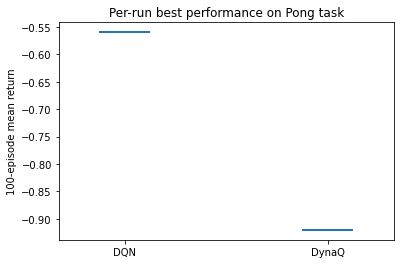

In [26]:
plot_performance(load_records("DQN-Pong-PostCNN", range(1,2)), load_records("DynaQ-Pong-PostCNN", range(1,2)), 'Pong')

### 3.1.1 DQN results on the Pong task {-}

#### 3.1.1.1 Training DQN on the Pong task {-}

A figure is shown below depicting smoothed on-policy training returns, greedy policy evaluation performed every 50 training episodes, and the Q loss (root mean squared error) over 1 run of 2000 training episodes applying DynaQ with perfect experience store on the Pong task.

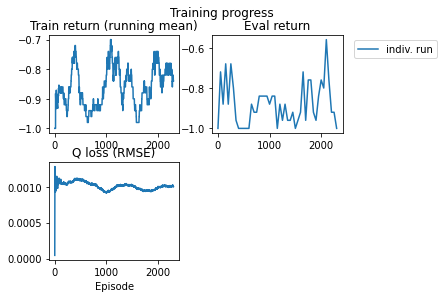

In [25]:
plot_training_curves(load_records("DQN-Pong-PostCNN", range(1,2)))

Training on the task showed mixed results, with occasional transient jumps in performance (which were also captured in the evaluation data) and a possible upwards trend at the end of the run. The level of instability suggests that a larger neural network or lower training rate might be useful. The fact that the Q loss was relatively steady throughout training suggests that there was not a strong enough signal differentiating good from bad policies; this could perhaps be remediated by increasing the discount factor.

#### 3.1.1.2 Evaluating DQN on the Pong task {-}

As seen in the figure at the heading of Section 3.1, the best policy discovered by DQN on the Pong task received a mean reward of -0.56 over 100 episodes. This represents winning 22% of the points on average. This is certainly above chance level, but nevertheless very unimpressive performance on the task. It is worth noting that the Monte Carlo agent from which this CNN was extracted achieved a mean return of -0.02 using this CNN, so it is unlikely to be the fault of the feature extractor that DQN failed to achieve high performance.

### 3.1.2 DynaQ results on the Pong task {-}

#### 3.1.2.1 Training DynaQ on the Pong task {-}

A figure is shown below depicting smoothed on-policy training returns, greedy policy evaluation performed every 50 training episodes, the Q-function loss (root mean squared error), and the dynamics function representation loss (RMSE for reward and state plus cross-entropy for the termination flag), over 1 runs of 400 training episodes applying DynaQ to the Pong task.

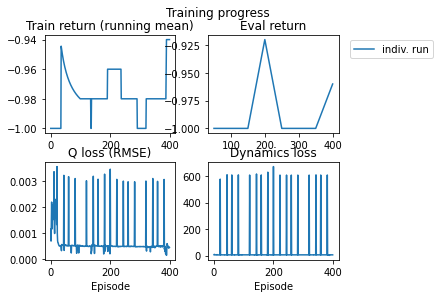

In [27]:
plot_training_curves(load_records("DynaQ-Pong-PostCNN", range(1,2)))

At this level, I am not comfortable saying that DynaQ discovers a policy better than chance. It is worth noting that the dynamics model and the Q function loss seem highly nonconvergent. Given the fact that loss spikes do not occur every episode, but that the player does not win as many episodes as there are loss spikes, I suspect that the issue is that the player cannot predict being able to hit the ball, and that the loss spikes occur because there are so many more state transitions where the player does not hit the ball than where it does.

#### 3.1.2.2 Evaluating DynaQ on the Pong task {-}

As seen in the figure at the heading of Section 3.1, the best policy discovered by this run of DynaQ achieved a 100-episode mean return of -0.92. This represents winning 4% of points on average, which I suspect is near or at chance level.

# 4 Discussion {-}

## 4.1 DQN vs DynaQ on the Pong task {-}

In this experiment I found that DynaQ with hybrid function approximation underperformed DynaQ with a perfect experience store ("DQN"). I have also found reason to believe that this is because DynaQ's dynamics model did not converge (as seen in the dynamics loss figure). While it is very possible that, had I had more time to tune hyperparameters, I could have found more compelling results, the challenge of training a dynamics model would remain.

In fact, we cannot possibly expect DynaQ to outperform DQN in this framework because the best that DynaQ can do is to perfectly approximate the information that the DQN's perfect experience store preserves by nature. Instead, this is a useful measure of the value that is lost by switching from a perfect experience store to one that uses a dynamics model. However, as discussed in class, there are significant advantages to be had using dynamics models in more sophisticated ways. If, instead of sampling (S, A) pairs from the agent's history, the dynamics model generated entirely new trajectories (as some of Michael's work with Dr. Piergiovanni does) then it could enable better interpolation between experienced trajectories and lead to more stable and sample-efficient learning.

# 5 Code availability {-}

You may find all of the code for this assignment, including supporting data, at https://github.com/ajleite/dyna-q-exploration. You may particularly find and test out this notebook at https://github.com/ajleite/continuous-rl-exploration/blob/main/PA3_DynaQ_Abe_Leite.ipynb